In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory that gets preserved as output when you create a version using "Save & Run All"

# **Hateful Meme Detection**

**CHINTHA YETHI RAJ**
**210108013**

In recent years, the proliferation of hateful content on social media platforms has emerged as a significant concern, necessitating robust detection mechanisms to safeguard online communities. This project aims to develop an advanced system for the detection of hateful memes, which are a particularly insidious form of harmful content combining images and text to convey hate speech or discrimination. The proposed solution leverages state-of-the-art machine learning techniques, including convolutional neural networks (CNNs) for image analysis and transformer-based models for natural language processing (NLP). By integrating these methodologies, the system can accurately interpret and assess the multimodal content of memes.

The core of the project involves creating a comprehensive dataset of labeled hateful and non-hateful memes, ensuring diversity in both visual and textual components to enhance the model's generalizability. We employ a multi-stage training process where the CNNs extract visual features, and the transformer models analyze textual data, followed by a fusion mechanism to combine these features for final classification. Additionally, we implement techniques to address challenges such as context variability, sarcasm, and subtlety in hate speech, which are prevalent in memes.

Performance evaluation of the system is conducted using standard metrics such as accuracy, precision, recall, and F1-score, along with a comparative analysis against existing state-of-the-art approaches. Preliminary results demonstrate the effectiveness of our model in accurately detecting hateful memes, highlighting its potential for deployment in real-world social media monitoring tools.

The project's contributions include not only a robust detection model but also insights into the challenges and nuances of multimodal hate speech detection. By enhancing the ability to automatically identify and mitigate the spread of hateful content, this project aims to contribute significantly to the creation of safer online environments.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   

## Problem <a class="anchor" id="problem"></a>

The rise of memes on social media has turned them into influential communication tools. Unfortunately, this medium is also being used to spread hate speech and harmful content. Detecting hateful memes is challenging due to their multimodal nature, where harmful intent can be subtly embedded in both images and text. Traditional detection systems focusing only on text or images are insufficient for understanding these nuances.

Key Questions Addressed in the Project

1. How can we effectively detect hate speech in memes?

    Memes require an integrated approach to understand the interplay between visual and textual elements.
    
2. What machine learning models and techniques are most effective for this task?

    Exploring and combining CNNs for image processing and transformers for text analysis to create an accurate classification system.
    
3. How can we create a comprehensive dataset for training and evaluation?

    Collecting and annotating a diverse set of memes reflecting real-world variability for robust model training.
    
4. What challenges arise in detecting subtle and context-dependent hate speech in memes?

    Addressing issues like sarcasm, irony, and cultural references that obscure harmful intent.
    
5. How can we evaluate the performance of the detection system?

    Using metrics like accuracy, precision, recall, and F1-score, and comparing results with existing methods.
    
6. What are the ethical considerations and potential biases in detecting hateful content?

    Ensuring fairness, avoiding censorship of benign content, and addressing biases in training data.
    
This project aims to develop an effective hateful meme detection system to enhance online safety and inclusivity.

## Data Understanding<a class="anchor" id="data_understanding"></a>

For this project, we will utilize the Facebook Hateful Memes Detection Challenge dataset. This dataset is specifically designed for multimodal hate speech detection and includes a diverse collection of memes, combining images and associated text. Each meme is labeled as either hateful or non-hateful. The dataset provides a balanced mix of various cultural references and contexts, ensuring comprehensive coverage for training and evaluation. By leveraging this dataset, we aim to build and validate a robust system capable of accurately detecting hateful content in memes.

In [1]:
%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torchvision

In [ ]:
data_dir = "/kaggle/input/data-intensive/data/"
train_path = data_dir + "train.jsonl"
dev_path = data_dir  + "dev.jsonl"
test_path = data_dir + "test.jsonl"

In [ ]:
train_samples_frame = pd.read_json(train_path, lines=True)
val_samples_frame = pd.read_json(dev_path, lines=True)
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
train_samples_frame.label.value_counts()

label
0    5450
1    3050
Name: count, dtype: int64

In [ ]:
train_samples_frame['length'] = train_samples_frame['text'].apply(len)
# Define the number of bins
num_bins = 3

# Create bins automatically
train_samples_frame['length_bins'] = pd.cut(train_samples_frame['length'], bins=num_bins)


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


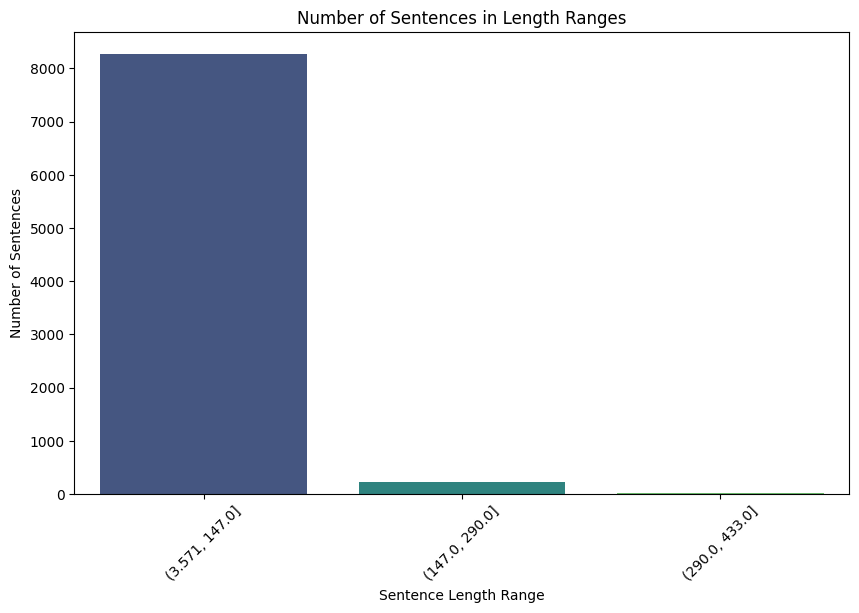

In [ ]:
import seaborn as sns

# Using Seaborn for better aesthetics
plt.figure(figsize=(10, 6))
sns.countplot(x='length_bins', data=train_samples_frame, palette='viridis')

plt.title('Number of Sentences in Length Ranges')
plt.xlabel('Sentence Length Range')
plt.ylabel('Number of Sentences')
plt.xticks(rotation=45)
plt.show()


In [ ]:
max_length = train_samples_frame['length'].max()
print("Maximum Length:", max_length)
median_length = train_samples_frame['length'].median()
print("Median Length:", median_length)


Maximum Length: 433
Median Length: 54.0


In [ ]:
train_samples_frame

,id,img,label,text,length,length_bins
0,42953,img/42953.png,0,its their character not their color that matters,48,"(3.571, 147.0]"
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,58,"(3.571, 147.0]"
2,13894,img/13894.png,0,putting bows on your pet,24,"(3.571, 147.0]"
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,70,"(3.571, 147.0]"
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",51,"(3.571, 147.0]"
...,...,...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me,33,"(3.571, 147.0]"
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...,96,"(3.571, 147.0]"
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...,130,"(3.571, 147.0]"
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...,122,"(3.571, 147.0]"


## Data Preparation<a class="anchor" id="data_preparation"></a>

Explain what kind of data transformations, feature selection and/or engineering you will perform.

In [ ]:
train_samples_frame = train_samples_frame[train_samples_frame['length'] < 64]

In [ ]:
train_samples_frame = train_samples_frame.sample(2000)

In [ ]:
train_texts = list(train_samples_frame['text'])
val_texts = list(val_samples_frame['text'])
train_labels = list(train_samples_frame['label'])
val_labels = list(val_samples_frame['label'])

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
train_images = []
val_images = []

for i in list(val_samples_frame['img']):
    path = data_dir + i
    img = load_img(path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    val_images.append(img_array)

for i in list(train_samples_frame['img']):
    path = data_dir + i
    img = load_img(path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    train_images.append(img_array)

train_images = np.array(train_images)
val_images = np.array(val_images)

2024-05-31 07:59:53.311853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 07:59:53.311960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 07:59:53.482670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D,Flatten
from transformers import TFBertModel, BertTokenizer
import numpy as np

# Load pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
    outputs = bert_model(inputs)
    outputs = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token embedding
    return outputs



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_text_embeddings = get_bert_embeddings(train_texts)
val_text_embeddings = get_bert_embeddings(val_texts)
train_text_embeddings = np.array(train_text_embeddings)
val_text_embeddings = np.array(val_text_embeddings)

In [ ]:
train_text_embeddings.shape

(2000, 768)

In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

## Modeling<a class="anchor" id="modeling"></a>

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D,Flatten, Dropout

# Load pre-trained InceptionResNetV2 model, exclude top layers
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128 , 128, 3))

# Custom model combining InceptionResNetV2 and BERT embeddings
image_input = base_model.input
x = base_model(image_input)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

text_input = Input((768,))
text_input = Flatten()(text_input)

combined = Concatenate()([x, text_input])

x_last = Dense(1024, activation = 'relu')(combined)
x_last = Dense(512, activation = 'relu')(x_last)
x_last = Dropout(0.5)(x_last)
x_last = Dense(256, activation = 'relu')(x_last)
x_last = Dense(128, activation = 'relu')(x_last)
x_last = Dropout(0.5)(x_last)
predictions = Dense(2, activation='softmax')(x_last)


# Define the final model
model = Model(inputs=[image_input, text_input], outputs=predictions)

# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])



219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_resnet_v2 │ (None, 2, 2,      │ 54,336,736 │ input_layer[2][0] │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1536)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_784CL… │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304)      │          0 │ flatten[2][0],    │
│ (Concatenate)       │                   │            │ keras_tensor_784… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,360,320 │ concatenate[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_1[2][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout[2][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dense_2[2][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[2][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │        258 │ dropout_1[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,386,338 (218.91 MB)

 Trainable params: 57,325,794 (218.68 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [ ]:
# Train the model
model.fit([train_images, train_text_embeddings], train_labels, epochs=20, batch_size=32,validation_data=([val_images, val_text_embeddings], val_labels))

Epoch 1/20


I0000 00:00:1717142666.355574      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.6116 - loss: 0.8099 - val_accuracy: 0.4720 - val_loss: 2.5680
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.6896 - loss: 0.6241 - val_accuracy: 0.5000 - val_loss: 6.9255
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.6992 - loss: 0.6060 - val_accuracy: 0.5040 - val_loss: 1.6095
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.6999 - loss: 0.5950 - val_accuracy: 0.5200 - val_loss: 0.8964
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.7159 - loss: 0.5458 - val_accuracy: 0.5160 - val_loss: 0.8789
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7226 - loss: 0.5213 - val_accuracy: 0.5040 - val_loss: 1.7301
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7667 - loss: 0.4767 - val_accuracy: 0.5100 - val_loss: 0.8385
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.8103 - loss: 0.4321 - val_accuracy: 0.5020 

In [ ]:
predictions = model.predict([val_images, val_text_embeddings])

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 860ms/step


In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(val_labels, predictions)


0.488

              precision    recall  f1-score   support

 non_hateful       0.49      0.84      0.62       250
     hateful       0.46      0.14      0.21       250

    accuracy                           0.49       500
   macro avg       0.48      0.49      0.42       500
weighted avg       0.48      0.49      0.42       500



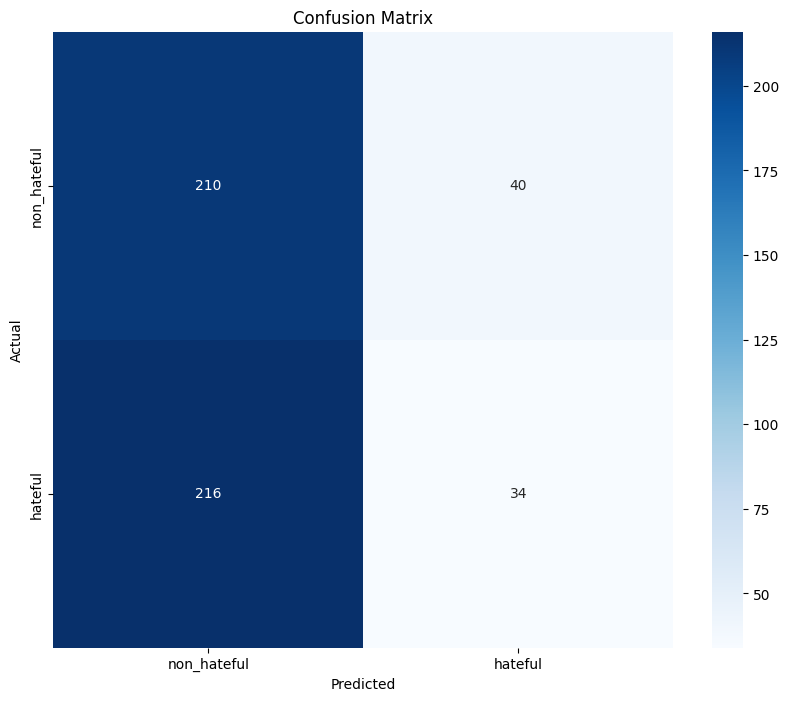

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(val_labels, predictions, target_names = ['non_hateful','hateful']))
cm = confusion_matrix(val_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['non_hateful','hateful'], yticklabels= ['non_hateful','hateful'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()